# Project 2
# Rebalancing Strategy 

#### 2023-1학기
#### Version: 2023-05-16-v2

> 분반: 01
>
> 학번: 
>
> 학과: 
>
> 이름: 

### To Do List

- rebalancing() 완성 (만약 BTC, ETH 외의 암호화폐를 추가적으로 고려하고 싶은 경우)
- 여러 자산 비율을 사용하여 성능 테스트


In [1]:
# 런타임이 종료되면 이 코드셀은 매번 다시 실행해야 합니다.

# pyupbit 설치
!pip install pyupbit

In [2]:
# Import

import numpy as np
import pandas as pd
import datetime

import pyupbit


In [3]:
# trading_helper 설치 및 버전 확인

!wget https://esohn.be/python/trading_helper.py -O trading_helper.py

import trading_helper
import importlib
importlib.reload(trading_helper)

print( f'Trading Helper Version: {trading_helper.TRADING_HELPER_VERSION}'  )

--2023-06-07 13:45:29--  https://esohn.be/python/trading_helper.py
Resolving esohn.be (esohn.be)... 18.64.8.126, 18.64.8.8, 18.64.8.120, ...
Connecting to esohn.be (esohn.be)|18.64.8.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6252 (6.1K) [text/x-python]
Saving to: ‘trading_helper.py’

trading_helper.py   100%[===================>]   6.11K  --.-KB/s    in 0s      

2023-06-07 13:45:29 (5.82 GB/s) - ‘trading_helper.py’ saved [6252/6252]

Trading Helper Version: 2023.05.15-v1


### AUTH_CODE는 반드시 자신의 Auth Code로 변경해야 합니다.

In [4]:
# ------------------------------------------------------------------------------------------------------
# https://esohn.be/account 의 AUTH CODE 로 실행 로그 기록
# ------------------------------------------------------------------------------------------------------

'''
AUTH_CODE = 'f587ea651febd5446efc61d5e3fef123'  -> 아래에 이렇게 auth code를 붙여넣으세요.
'''
AUTH_CODE = '2b435454dd9860ceba97f35f7aa030f0'

# Do not edit
trading_helper.set_auth_code( AUTH_CODE )


Log updated! (2023-1 YCS1009-01 박희영)


In [5]:
# 가격정보 가져오기

from_date = '20220501'
to_date = '20230501'

df = trading_helper.get_multiple(from_date, to_date)


df.head()

,Unnamed: 0,index,price_btc,price_eth,price_doge,price_ada,bal_krw,bal_btc,bal_eth,bal_doge,...,bal2_ada,target_btc,target_eth,target_doge,target_ada,trade_btc,trade_eth,trade_doge,trade_ada,value
0,0,2022-05-01 09:00:00,49283000.0,3570000.0,166.0,996.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2022-05-02 09:00:00,49383000.0,3625000.0,170.0,1010.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2022-05-03 09:00:00,49501000.0,3667000.0,168.0,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2022-05-04 09:00:00,48772000.0,3595000.0,167.0,997.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2022-05-05 09:00:00,50631000.0,3752000.0,173.0,1140.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 아래 코드셀을 복사 해서 프로젝트 코드 페이지에 붙여넣으세요

In [6]:
# ------------------------------------------------------------------------------------------------------
# - 코드를 완성했다면 이 코드셀만 복사해서 competition 페이지 Rebalancing 탭에 라운드 별 코드 항목으로 붙여넣습니다.
# - 연습할 때는 다음과 같은 이유로 프로젝트 페이지의 에디터에서 직접 연습하지 말고 Colab에서 연습하세요. 
#   + Colab의 연습은 서버에 횟수가 기록되어 평가에 반영됩니다.
#   + Colab 노트북 자체에도 변경 history가 누적 됩니다. (부정행위 방지)
#   + 프로젝트 페이지에서 submit 횟수가 지나치게 빈번한 경우 submit이 일정시간 제한될 수 있습니다.
# ------------------------------------------------------------------------------------------------------

# Given Code Version 2023.05.16-v2

import numpy as np
import pandas as pd
import datetime

# rebalancing() 암호화폐 포트폴리오 리밸런싱 함수
'''
* ratio_  자산배분 비율 (총 합은 반드시 1.0이어야 함)
  투자하지 않는 암호화폐는 0으로 남겨둠
  
  예) 원화 10%, 비트코인(BTC) 50%, 이더리움(ETH) 40%
      ratio_krw = 0.1
      ratio_btc = 0.5
      ratio_eth = 0.4
      ratio_doge = 0.0
      ratio_ada = 0.0

  예) 원화 70%, 비트코인(BTC) 10%, 이더리움(ETH) 10%, 도지코인(DOGE) 5%, 에이다(ADA) 5%
      ratio_krw = 0.7
      ratio_btc = 0.1
      ratio_eth = 0.1
      ratio_doge = 0.05
      ratio_ada = 0.05

* threshold - 최소한으로 요구되는 총 자산 대비 변동 비율 (%)

  기본값 0: 조금이라도 변동될 때 매매
  예) 0.001: 전체 자산의 0.1% 변동시 매매, 0.005: 전체 자산의 0.5% 변동시 매매


* fee - 수수료, 기본값 0.001 (변경 없음)

* init_krw - 초기 투자금액, 기본값 100000000 (변경 없음)
'''

# Qualification 라운드 에서는 지정된 암호화폐 비율과 threshold 0.0을 사용해야 하며
# 그 외의 라운드에서는 암포화폐 비율과 threshold를 자유롭게 사용할 수 있음

# ------------------------------------------------
# EDITABLE (1)
#
DEFAULT_RATIO_KRW = 0.0
DEFAULT_RATIO_BTC = 0.65
DEFAULT_RATIO_ETH = 0.35
DEFAULT_RATIO_DOGE = 0.0
DEFAULT_RATIO_ADA = 0.0

DEFAULT_THRESHOLD = 0.0 # Qualification 라운드 에서는 이 값을 0.0으로
# ------------------------------------------------

def rebalancing( df, ratio_krw=DEFAULT_RATIO_KRW, ratio_btc=DEFAULT_RATIO_BTC, ratio_eth=DEFAULT_RATIO_ETH, ratio_doge=DEFAULT_RATIO_DOGE, ratio_ada=DEFAULT_RATIO_ADA, threshold=DEFAULT_THRESHOLD, fee=0.001, init_krw=100000000 ):

    # -------------------------------------------------------------------------------
    # DO NOT EDIT
    #
    ratio_sum = ratio_krw + ratio_btc + ratio_eth + ratio_doge + ratio_ada
    if abs(ratio_sum - 1.0) > 0.0001:
        print(f'The sum of the ratios must be 1. ({ratio_sum})')
        return
    # -------------------------------------------------------------------------------

    row_index = 0

    # 데이터프레임의 모든 행에 대해서 반복
    for row_index in range( len( df ) ):

        # 현재 데이터: cur_data
        cur_data = df.loc[ row_index, : ].copy()
        # 이전 데이터: prev_data
        if row_index > 0:
            prev_data = df.loc[ row_index-1, : ].copy()



        #------------------------
        # Balance 계산 (bal_)
        # 하루 전의 계산 후 잔고(bal2_)를 현재의 계산 전 잔고로 가져옴(bal_)
        if row_index == 0:
            # 첫째 날이라면 잔고는 krw만 존재
            cur_data[ 'bal_krw' ] = init_krw
        else:
            # 둘째 날 부터는 이전 날 계산 후 잔고(bal2_)를 현재 잔고(bal_)로 대입
            cur_data[ 'bal_krw' ] = prev_data[ 'bal2_krw' ]
            cur_data[ 'bal_btc' ] = prev_data[ 'bal2_btc' ]
            cur_data[ 'bal_eth' ] = prev_data[ 'bal2_eth' ]
            cur_data[ 'bal_doge' ] = prev_data[ 'bal2_doge' ]
            cur_data[ 'bal_ada' ] = prev_data[ 'bal2_ada' ]
            

        #------------------------
        # Total Value 계산 (value)
        # 전체 자산의 가치를 모두 합산
        cur_data[ 'value' ] = cur_data[ 'bal_krw' ]
        cur_data[ 'value' ] += cur_data[ 'price_btc' ] * cur_data[ 'bal_btc' ]
        cur_data[ 'value' ] += cur_data[ 'price_eth' ] * cur_data[ 'bal_eth' ]
        cur_data[ 'value' ] += cur_data[ 'price_doge' ] * cur_data[ 'bal_doge' ] # EDITABLE (2)
        cur_data[ 'value' ] += cur_data[ 'price_ada' ] * cur_data[ 'bal_ada' ] # EDITABLE (3)                                
                                

        #------------------------
        # Target 계산 (target_)
        # 비율에 따라 다시 조정되어야 할 목표 잔고 계산
        cur_data[ 'target_btc' ] = ratio_btc * cur_data[ 'value' ] / cur_data[ 'price_btc' ]
        cur_data[ 'target_eth' ] = ratio_eth * cur_data[ 'value' ] / cur_data[ 'price_eth' ]
        cur_data[ 'target_doge' ] = ratio_doge * cur_data[ 'value' ] / cur_data[ 'price_doge' ]    # EDITABLE (4)
        cur_data[ 'target_ada' ] = ratio_ada * cur_data[ 'value' ] / cur_data[ 'price_ada' ]      # EDITABLE (5)


        #------------------------
        # Trading Amount 계산 (trade_)
        # Target 잔고를 위해 매매해야 할 양을 계산
        cur_data[ 'trade_btc' ] = cur_data[ 'target_btc' ] - cur_data[ 'bal_btc' ]
        cur_data[ 'trade_eth' ] = cur_data[ 'target_eth' ] - cur_data[ 'bal_eth' ]
        cur_data[ 'trade_doge' ] = cur_data[ 'target_doge' ] - cur_data[ 'bal_doge' ]  # EDITABLE (6)
        cur_data[ 'trade_ada' ] = cur_data[ 'target_ada' ] - cur_data[ 'bal_ada' ]  # EDITABLE (7)



        #------------------------
        # 매매해야 할 양의 절대값이 총 자산의 일정 %를 넘지 않으면 매매하지 않음
        th_value = threshold * cur_data[ 'value' ]
        amount_btc = abs( cur_data[ 'trade_btc' ] * cur_data[ 'price_btc' ] )
        amount_eth = abs( cur_data[ 'trade_eth' ] * cur_data[ 'price_eth' ] )
        amount_doge = abs( cur_data[ 'trade_doge' ] * cur_data[ 'price_doge' ] )  # EDITABLE (8)
        amount_ada = abs( cur_data[ 'trade_ada' ] * cur_data[ 'price_ada' ] )  # EDITABLE (9)


        #--------------------------------------------------------------------------------------------------------------------
        # DO NOT EDIT
        # 계산 후 잔고 준비
        cur_data[ 'bal2_krw' ] = cur_data[ 'bal_krw' ]
        cur_data[ 'bal2_btc' ] = cur_data[ 'bal_btc' ]
        cur_data[ 'bal2_eth' ] = cur_data[ 'bal_eth' ]
        cur_data[ 'bal2_doge' ] = cur_data[ 'bal_doge' ]
        cur_data[ 'bal2_ada' ] = cur_data[ 'bal_ada' ]

        if amount_btc >= th_value:
            # BTC 잔고 변경 
            cur_data[ 'bal2_btc' ] += cur_data[ 'trade_btc' ]
            # krw 잔고 변경 (BTC 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_btc' ] * cur_data[ 'price_btc' ] + amount_btc * fee

        if amount_eth >= th_value:
            # ETH 잔고 변경 
            cur_data[ 'bal2_eth' ] += cur_data[ 'trade_eth' ]
            # krw 잔고 변경 (ETH 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_eth' ] * cur_data[ 'price_eth' ] + amount_eth * fee

        if amount_doge >= th_value:
            # DOGE 잔고 변경 
            cur_data[ 'bal2_doge' ] += cur_data[ 'trade_doge' ]
            # krw 잔고 변경 (DOGE 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_doge' ] * cur_data[ 'price_doge' ] + amount_doge * fee

        if amount_ada >= th_value:
            # ADA 잔고 변경 
            cur_data[ 'bal2_ada' ] += cur_data[ 'trade_ada' ]
            # krw 잔고 변경 (ADA 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_ada' ] * cur_data[ 'price_ada' ] + amount_ada * fee


        #--------------------------------------------------------------------------------------------------------------------
        # DO NOT EDIT
        #
        df.loc[ row_index, : ] = cur_data

        row_index += 1
        #--------------------------------------------------------------------------------------------------------------------




### 하나씩 비율을 조절하며 HPR, MDD 를 확인해 보는 방법

In [7]:
# 비트코인만 100%

rebalancing( df, ratio_krw=0.0, ratio_btc=1.0, ratio_eth=0.0, ratio_doge=0.0, ratio_ada=0.0, threshold= 0.0001 )

hpr, mdd = trading_helper.check_performance_rebal(df)

print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


HPR=-20.8 MDD=58.4


In [8]:
# 비트코인 60% 이더리움 40%

rebalancing( df, ratio_krw=0.0, ratio_btc=0.6, ratio_eth=0.4, ratio_doge=0.0, ratio_ada=0.0, threshold= 0.0001 )

hpr, mdd = trading_helper.check_performance_rebal(df)

print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


HPR=-23.1 MDD=58.3


### 비트코인, 이더리움, 도지코인, 에이다 그냥 가지고 있을 때와 리밸런싱 전략 4개의 HPR, MDD 비교

In [21]:

rebalancing( df, ratio_krw=0.0, ratio_btc=1.0, ratio_eth=0.0, ratio_doge=0.0, ratio_ada=0.0 )
s_btc = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.0, ratio_btc=0.0, ratio_eth=1.0, ratio_doge=0.0, ratio_ada=0.0 )
s_eth = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.0, ratio_btc=0.0, ratio_eth=0.0, ratio_doge=1.0, ratio_ada=0.0 )
s_doge = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.0, ratio_btc=0.0, ratio_eth=0.0, ratio_doge=0.0, ratio_ada=1.0 )
s_ada = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.7, ratio_btc=0.1, ratio_eth=0.1, ratio_doge=0.05, ratio_ada=0.05 )
s1 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.6, ratio_btc=0.2, ratio_eth=0.1, ratio_doge=0.05, ratio_ada=0.05 )
s2 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.3, ratio_btc=0.2, ratio_eth=0.3, ratio_doge=0.1, ratio_ada=0.1 )
s3 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing( df, ratio_krw=0.2, ratio_btc=0.2, ratio_eth=0.2, ratio_doge=0.2, ratio_ada=0.2 )
s4 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


HPR=-20.8 MDD=58.4
HPR=-29.4 MDD=65.0
HPR=0.0 MDD=0.0
HPR=0.0 MDD=0.0
HPR=-2.7 MDD=15.4
HPR=-4.4 MDD=21.1
HPR=-9.2 MDD=35.7
HPR=-6.6 MDD=28.7


# 추가 코드!

In [10]:
rebalancing(df, ratio_krw = 0.8,
ratio_btc = 0,
ratio_eth = 0,
ratio_doge = 0.2,
ratio_ada = 0
)
s5 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing(df, ratio_krw = 0.9,
ratio_btc = 0,
ratio_eth = 0,
ratio_doge = 0.1,
ratio_ada = 0
)
s6 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )

rebalancing(df, ratio_krw = 0.9,
ratio_btc = 0.025,
ratio_eth = 0.025,
ratio_doge = 0.025,
ratio_ada = 0.025
)
s7 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


HPR=-2.1 MDD=15.6
HPR=-0.6 MDD=8.1
HPR=-1.6 MDD=7.3


In [11]:
rebalancing(df, ratio_krw = 0.9,
ratio_btc = 0,
ratio_eth = 0,
ratio_doge = 0.7999999999999996,
ratio_ada = -0.6999999999999996,
threshold = 0.7999999999999996
)
s7 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


HPR=-28.5 MDD=48.1


In [12]:
rebalancing(df, ratio_krw = 0.9,
ratio_btc = 0,
ratio_eth = 0,
ratio_doge = 0.09999999999999987,
ratio_ada = 1.3877787807814457e-16,
threshold = 0.09999999999999987
            
)
s7 = df['value'].copy()
hpr, mdd = trading_helper.check_performance_rebal(df)
print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


HPR=-3.6 MDD=6.6


In [13]:

for i in np.arange(0, 0.6, 0.1):
    x = i
    y = 0.5 - i

    print( x, y, end=' ' )

    rebalancing( df, ratio_krw= 0.5, ratio_btc=0, ratio_eth=0, ratio_doge=x, ratio_ada=y )
    s4 = df['value'].copy()
    hpr, mdd = trading_helper.check_performance_rebal(df)
    print( f'HPR={hpr*100:.1f} MDD={mdd*100:.1f}' )


0.0 0.5 HPR=-21.3 MDD=44.9
0.1 0.4 HPR=-18.4 MDD=40.5
0.2 0.3 HPR=-16.0 MDD=36.1
0.30000000000000004 0.19999999999999996 HPR=-13.9 MDD=31.6
0.4 0.09999999999999998 HPR=-12.3 MDD=33.1
0.5 0.0 HPR=-11.1 MDD=35.1


In [14]:
for i in np.arange(0, 0.5, 0.05):
    x = i
    y = 0.5 - i

    # print( x, y, end=' ' )
    ratio_krw= 0.5
    ratio_btc=0
    ratio_eth=0
    ratio_doge=x 
    ratio_ada=y
    threshold=0.0005
    
    rebalancing( df, ratio_krw, ratio_btc, ratio_eth, ratio_doge, ratio_ada, threshold )
    s4 = df['value'].copy()
    hpr, mdd = trading_helper.check_performance_rebal(df)
    print(f'ratio_krw={ratio_krw}, ratio_btc={ratio_btc}, ratio_eth={ratio_eth}, ratio_doge={ratio_doge}, ratio_ada={ratio_ada}, threshold={threshold}')
    print( f'HPR={hpr*100:.1f} MDD={mdd*100:.3f}' )
    print()

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.0, ratio_ada=0.5, threshold=0.0005
HPR=-21.3 MDD=44.916

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.05, ratio_ada=0.45, threshold=0.0005
HPR=-19.8 MDD=42.725

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.1, ratio_ada=0.4, threshold=0.0005
HPR=-18.5 MDD=40.525

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.15000000000000002, ratio_ada=0.35, threshold=0.0005
HPR=-17.2 MDD=38.309

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.2, ratio_ada=0.3, threshold=0.0005
HPR=-16.0 MDD=36.085

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.25, ratio_ada=0.25, threshold=0.0005
HPR=-14.9 MDD=33.847

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.30000000000000004, ratio_ada=0.19999999999999996, threshold=0.0005
HPR=-13.9 MDD=31.600

ratio_krw=0.5, ratio_btc=0, ratio_eth=0, ratio_doge=0.35000000000000003, ratio_ada=0.14999999999999997, threshold=0.0005
HPR=-13.0 MDD=32.155

ratio_krw=0.5, ratio_btc=0,

### 그래프 그려보기

<Axes: >

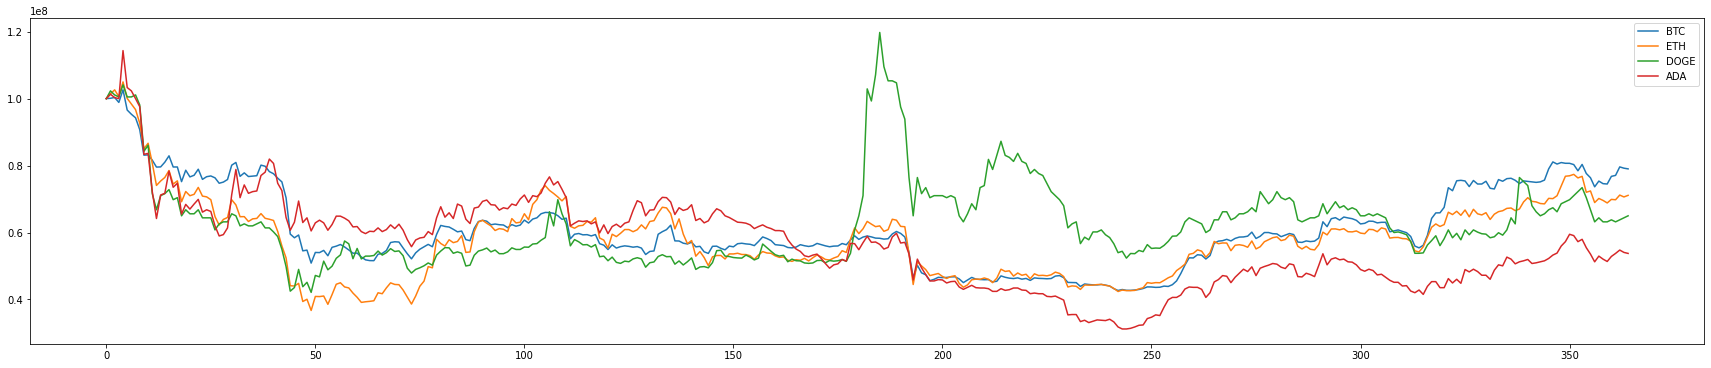

In [15]:

df2 = pd.DataFrame()
df2['BTC'] = s_btc
df2['ETH'] = s_eth
df2['DOGE'] = s_doge
df2['ADA'] = s_ada



df2.plot( figsize=(30,6) )

In [16]:
df2

,BTC,ETH,DOGE,ADA
0,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08
1,1.001029e+08,1.014406e+08,1.023096e+08,1.013056e+08
2,1.003420e+08,1.026158e+08,1.011059e+08,1.003025e+08
3,9.886427e+07,1.006010e+08,1.005041e+08,1.000016e+08
4,1.026326e+08,1.049944e+08,1.041150e+08,1.143448e+08
...,...,...,...,...
360,7.677934e+07,6.990301e+07,6.379301e+07,5.285942e+07
361,7.706921e+07,6.979108e+07,6.319118e+07,5.376214e+07
362,7.960508e+07,7.119026e+07,6.379301e+07,5.476516e+07
363,7.922399e+07,7.063058e+07,6.439483e+07,5.406305e+07


<Axes: >

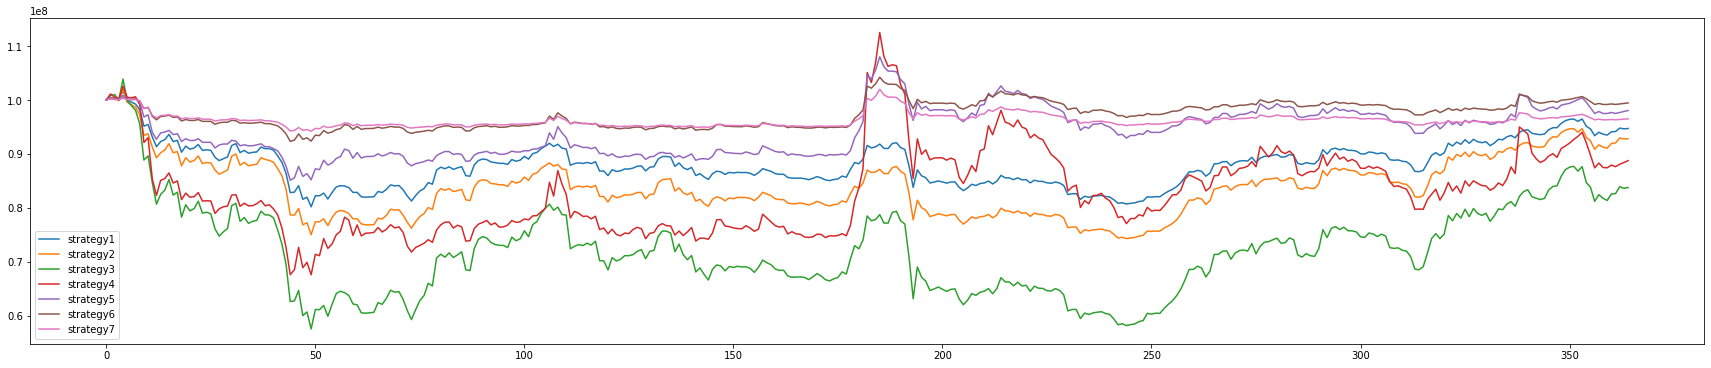

In [17]:
df2 = pd.DataFrame()

df2['strategy1'] = s1
df2['strategy2'] = s2
df2['strategy3'] = s3
df2['strategy4'] = s4
df2['strategy5'] = s5
df2['strategy6'] = s6
df2['strategy7'] = s7
df2.plot( figsize=(30,6) )

In [18]:
df2

,strategy1,strategy2,strategy3,strategy4,strategy5,strategy6,strategy7
0,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08
1,1.003351e+08,1.003454e+08,1.008143e+08,1.011046e+08,1.004619e+08,1.002310e+08,1.002310e+08
2,1.003664e+08,1.004006e+08,1.009939e+08,1.005186e+08,1.002252e+08,1.001128e+08,1.001105e+08
3,9.997631e+07,9.986256e+07,1.000106e+08,1.002340e+08,1.001057e+08,1.000531e+08,1.000502e+08
4,1.016903e+08,1.019552e+08,1.038765e+08,1.025723e+08,1.008249e+08,1.004125e+08,1.004117e+08
...,...,...,...,...,...,...,...
360,9.409318e+07,9.193322e+07,8.255285e+07,8.791967e+07,9.767878e+07,9.926003e+07,9.637554e+07
361,9.414917e+07,9.202252e+07,8.263819e+07,8.762122e+07,9.749433e+07,9.916631e+07,9.631530e+07
362,9.478019e+07,9.294205e+07,8.391158e+07,8.807815e+07,9.767989e+07,9.926067e+07,9.637554e+07
363,9.464382e+07,9.276370e+07,8.360444e+07,8.839538e+07,9.786404e+07,9.935423e+07,9.643578e+07


# 코드 보관 장소 
### 아래에 보관하고 싶은 코드를 자유롭게 수정/추가할 수 있습니다.
---

### Qual. Round 1,2 Code

In [19]:
# ------------------------------------------------------------------------------------------------------
# - 코드를 완성했다면 이 코드셀만 복사해서 competition 페이지 Rebalancing 탭에 라운드 별 코드 항목으로 붙여넣습니다.
# - 연습할 때는 다음과 같은 이유로 프로젝트 페이지의 에디터에서 직접 연습하지 말고 Colab에서 연습하세요. 
#   + Colab의 연습은 서버에 횟수가 기록되어 평가에 반영됩니다.
#   + Colab 노트북 자체에도 변경 history가 누적 됩니다. (부정행위 방지)
#   + 프로젝트 페이지에서 submit 횟수가 지나치게 빈번한 경우 submit이 일정시간 제한될 수 있습니다.
# ------------------------------------------------------------------------------------------------------

# Given Code Version 2023.05.16-v2

import numpy as np
import pandas as pd
import datetime

# rebalancing() 암호화폐 포트폴리오 리밸런싱 함수
'''
* ratio_  자산배분 비율 (총 합은 반드시 1.0이어야 함)
  투자하지 않는 암호화폐는 0으로 남겨둠
  
  예) 원화 10%, 비트코인(BTC) 50%, 이더리움(ETH) 40%
      ratio_krw = 0.7
      ratio_btc = 0.1
      ratio_eth = 0.1
      ratio_doge = 0.05
      ratio_ada = 0.05

  예) 원화 70%, 비트코인(BTC) 10%, 이더리움(ETH) 10%, 도지코인(DOGE) 5%, 에이다(ADA) 5%
      ratio_krw = 0.7
      ratio_btc = 0.1
      ratio_eth = 0.1
      ratio_doge = 0.05
      ratio_ada = 0.05

* threshold - 최소한으로 요구되는 총 자산 대비 변동 비율 (%)

  기본값 0: 조금이라도 변동될 때 매매
  예) 0.001: 전체 자산의 0.1% 변동시 매매, 0.005: 전체 자산의 0.5% 변동시 매매


* fee - 수수료, 기본값 0.001 (변경 없음)

* init_krw - 초기 투자금액, 기본값 100000000 (변경 없음)
'''

# Qualification 라운드 에서는 지정된 암호화폐 비율과 threshold 0.0을 사용해야 하며
# 그 외의 라운드에서는 암포화폐 비율과 threshold를 자유롭게 사용할 수 있음

# ------------------------------------------------
# EDITABLE (1)
#
DEFAULT_RATIO_KRW = 0.7
DEFAULT_RATIO_BTC = 0.1
DEFAULT_RATIO_ETH = 0.1
DEFAULT_RATIO_DOGE = 0.05
DEFAULT_RATIO_ADA = 0.05

DEFAULT_THRESHOLD = 0.0 # Qualification 라운드 에서는 이 값을 0.0으로
# ------------------------------------------------

def rebalancing( df, ratio_krw=DEFAULT_RATIO_KRW, ratio_btc=DEFAULT_RATIO_BTC, ratio_eth=DEFAULT_RATIO_ETH, ratio_doge=DEFAULT_RATIO_DOGE, ratio_ada=DEFAULT_RATIO_ADA, threshold=DEFAULT_THRESHOLD, fee=0.001, init_krw=100000000 ):

    # -------------------------------------------------------------------------------
    # DO NOT EDIT
    #
    ratio_sum = ratio_krw + ratio_btc + ratio_eth + ratio_doge + ratio_ada
    if abs(ratio_sum - 1.0) > 0.0001:
        print(f'The sum of the ratios must be 1. ({ratio_sum})')
        return
    # -------------------------------------------------------------------------------

    row_index = 0

    # 데이터프레임의 모든 행에 대해서 반복
    for row_index in range( len( df ) ):

        # 현재 데이터: cur_data
        cur_data = df.loc[ row_index, : ].copy()
        # 이전 데이터: prev_data
        if row_index > 0:
            prev_data = df.loc[ row_index-1, : ].copy()



        #------------------------
        # Balance 계산 (bal_)
        # 하루 전의 계산 후 잔고(bal2_)를 현재의 계산 전 잔고로 가져옴(bal_)
        if row_index == 0:
            # 첫째 날이라면 잔고는 krw만 존재
            cur_data[ 'bal_krw' ] = init_krw
        else:
            # 둘째 날 부터는 이전 날 계산 후 잔고(bal2_)를 현재 잔고(bal_)로 대입
            cur_data[ 'bal_krw' ] = prev_data[ 'bal2_krw' ]
            cur_data[ 'bal_btc' ] = prev_data[ 'bal2_btc' ]
            cur_data[ 'bal_eth' ] = prev_data[ 'bal2_eth' ]
            cur_data[ 'bal_doge' ] = prev_data[ 'bal2_doge' ]
            cur_data[ 'bal_ada' ] = prev_data[ 'bal2_ada' ]
            

        #------------------------
        # Total Value 계산 (value)
        # 전체 자산의 가치를 모두 합산
        cur_data[ 'value' ] = cur_data[ 'bal_krw' ]
        cur_data[ 'value' ] += cur_data[ 'price_btc' ] * cur_data[ 'bal_btc' ]
        cur_data[ 'value' ] += cur_data[ 'price_eth' ] * cur_data[ 'bal_eth' ]
        cur_data[ 'value' ] += 0 # EDITABLE (2)
        cur_data[ 'value' ] += 0 # EDITABLE (3)                                
                                

        #------------------------
        # Target 계산 (target_)
        # 비율에 따라 다시 조정되어야 할 목표 잔고 계산
        cur_data[ 'target_btc' ] = ratio_btc * cur_data[ 'value' ] / cur_data[ 'price_btc' ]
        cur_data[ 'target_eth' ] = ratio_eth * cur_data[ 'value' ] / cur_data[ 'price_eth' ]
        cur_data[ 'target_doge' ] = 0    # EDITABLE (4)
        cur_data[ 'target_ada' ] = 0     # EDITABLE (5)


        #------------------------
        # Trading Amount 계산 (trade_)
        # Target 잔고를 위해 매매해야 할 양을 계산
        cur_data[ 'trade_btc' ] = cur_data[ 'target_btc' ] - cur_data[ 'bal_btc' ]
        cur_data[ 'trade_eth' ] = cur_data[ 'target_eth' ] - cur_data[ 'bal_eth' ]
        cur_data[ 'trade_doge' ] = 0    # EDITABLE (6)
        cur_data[ 'trade_ada' ] = 0     # EDITABLE (7)


        #------------------------
        # 매매해야 할 양의 절대값이 총 자산의 일정 %를 넘지 않으면 매매하지 않음
        th_value = threshold * cur_data[ 'value' ]
        amount_btc = abs( cur_data[ 'trade_btc' ] * cur_data[ 'price_btc' ] )
        amount_eth = abs( cur_data[ 'trade_eth' ] * cur_data[ 'price_eth' ] )
        amount_doge = 0    # EDITABLE (8)
        amount_ada = 0     # EDITABLE (9)

        #--------------------------------------------------------------------------------------------------------------------
        # DO NOT EDIT
        # 계산 후 잔고 준비
        cur_data[ 'bal2_krw' ] = cur_data[ 'bal_krw' ]
        cur_data[ 'bal2_btc' ] = cur_data[ 'bal_btc' ]
        cur_data[ 'bal2_eth' ] = cur_data[ 'bal_eth' ]
        cur_data[ 'bal2_doge' ] = cur_data[ 'bal_doge' ]
        cur_data[ 'bal2_ada' ] = cur_data[ 'bal_ada' ]

        if amount_btc >= th_value:
            # BTC 잔고 변경 
            cur_data[ 'bal2_btc' ] += cur_data[ 'trade_btc' ]
            # krw 잔고 변경 (BTC 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_btc' ] * cur_data[ 'price_btc' ] + amount_btc * fee

        if amount_eth >= th_value:
            # ETH 잔고 변경 
            cur_data[ 'bal2_eth' ] += cur_data[ 'trade_eth' ]
            # krw 잔고 변경 (ETH 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_eth' ] * cur_data[ 'price_eth' ] + amount_eth * fee

        if amount_doge >= th_value:
            # DOGE 잔고 변경 
            cur_data[ 'bal2_doge' ] += cur_data[ 'trade_doge' ]
            # krw 잔고 변경 (DOGE 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_doge' ] * cur_data[ 'price_doge' ] + amount_doge * fee

        if amount_ada >= th_value:
            # ADA 잔고 변경 
            cur_data[ 'bal2_ada' ] += cur_data[ 'trade_ada' ]
            # krw 잔고 변경 (ADA 매매 반영 + 수수료 차감)
            cur_data[ 'bal2_krw' ] -= cur_data[ 'trade_ada' ] * cur_data[ 'price_ada' ] + amount_ada * fee


        #--------------------------------------------------------------------------------------------------------------------
        # DO NOT EDIT
        #
        df.loc[ row_index, : ] = cur_data

        row_index += 1
        #--------------------------------------------------------------------------------------------------------------------




### Comp. Round 1 (MDD 20) Code

### Comp. Round 2 (MDD 10) Code

### Bonus Round (MDD 30) Code